In [1]:
from UTILITY_quickstart import *
import json

importedDefaultSettings = loadConfig("setLattice_configs/2024-10-14_twoBunch_baseline.yml")
    # "2024-10-14_twoBunch_baseline.yml" already has
    #     centerBC14 : False
    #     centerBC20 : False
    #     centerMFFF : False
    #     assertBC14Energy : False
    #     assertBC20Energy : False

#Ad hoc attempt to get real median energies (with wakes and CSR) to 4.5 and 10.0 GeV respectively
#importedDefaultSettings = importedDefaultSettings | { "L2EnergyOffset" : 80.0e6, "L2EnergyOffset" : 130.0e6 } 

In [2]:
csrTF = False

tao = initializeTao(
    inputBeamFilePathSuffix = importedDefaultSettings["inputBeamFilePathSuffix"],
    csrTF = csrTF,
    numMacroParticles=1e4,
    scratchPath = "/tmp",
    randomizeFileNames = True
)

setLattice(tao, **importedDefaultSettings)

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR off
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_configs/defaults.yml
Number of macro particles = 10000.0
Beam created, written to /tmp/beams/activeBeamFile_760711120188651468.h5, and reinit to tao


In [3]:
#PyTao monkey patch, from ChatGPT https://chatgpt.com/c/6842031d-dd38-800b-a4f1-5c98f857ffc0

import types

def safe_get_output(self, reset=True):
    n_lines = self.so_lib.tao_c_out_io_buffer_num_lines()
    lines = []
    for i in range(1, n_lines + 1):
        raw = self.so_lib.tao_c_out_io_buffer_get_line(i)
        try:
            lines.append(raw.decode('utf-8'))
        except UnicodeDecodeError:
            lines.append("[Error decoding output line]")
    if reset:
        self.so_lib.tao_c_out_io_buffer_reset()
    return lines

tao.get_output = types.MethodType(safe_get_output, tao)

In [4]:
L1MatchStrings, L2MatchStrings, L3MatchStrings, selectMarkers = getLinacMatchStrings(tao)
L0BMatchStrings = ["L0BF"]

In [5]:
#tao.cmd('show ele K19_6D -all')

In [6]:
# OPTIONAL: disable all apertures. Very nonphysical, but I want to see if this solves some headaches
totalNumElements = len(tao.lat_list("*", "ele.name"))
for eleII in range(totalNumElements):
    try:
        tao.cmd(f"set ele {eleII} APERTURE_AT = NO_APERTURE")
    except:
        pass

## Baseline

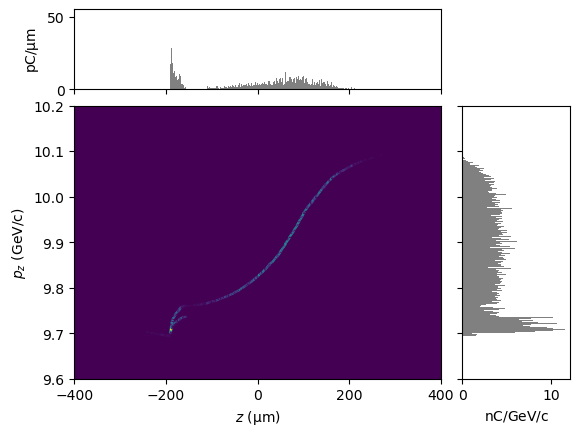

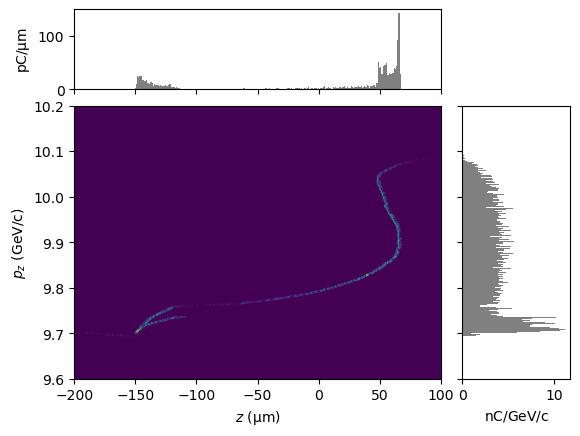

<Figure size 640x480 with 0 Axes>

In [7]:
trackBeam(tao, **importedDefaultSettings)

P = getBeamAtElement(tao, "BEGBC20")
display(plotMod(P, 'z', 'pz', bins=300, xlim = (-400e-6, 400e-6), ylim = (9.6e9, 10.2e9)))


P = getBeamAtElement(tao, "PENT")
display(plotMod(P, 'z', 'pz', bins=300, xlim = (-200e-6, 100e-6), ylim = (9.6e9, 10.2e9)))

plt.clf()

In [8]:
tao.lat_list("*", "ele.s")

array([ 0.00000000e+00, -8.69048001e-01,  0.00000000e+00, ...,
        1.02010829e+03,  1.02010829e+03,  1.02010829e+03])

In [9]:
tao.lat_list("*", "orbit.floor.x")

array([1.01951019e+01, 1.06935673e+01, 1.01951019e+01, ...,
       2.51682556e-04, 2.51682556e-04, 2.51682556e-04])

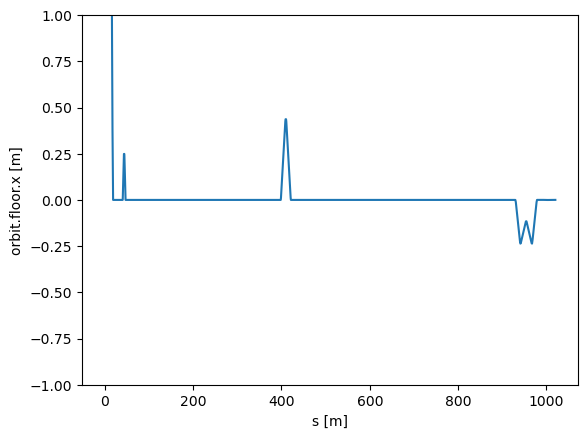

In [10]:
plt.plot(    
    tao.lat_list("*", "ele.s"),
    tao.lat_list("*", "orbit.floor.x")
)
#plt.xlim(0, 5)                 # X-axis from 0 to 5
plt.ylim(-1,1)                # Y-axis from 0 to 20
plt.xlabel("s [m]")         # X-axis label
plt.ylabel("orbit.floor.x [m]")     # Y-axis label

plt.show()

## Phase error only

In [11]:
#tao.cmd("show ele Q1EL -all")
tao.cmd('show ele K19_6D -all')

['Element # 1720',
 'Element Name: K19_6D',
 'Element Type:  "10ft"',
 'Element Alias:  "LI19:KLYS:61"',
 'Key: Lcavity',
 'S_start, S:    900.550670,    903.594770',
 'Ref_time_start, Ref_time:  3.003931E-06,  3.014085E-06',
 '',
 'Attribute values:',
 '    1  L                           =  3.0441000E+00 m        31  L_ACTIVE                    =  3.0441000E+00 m',
 '    2  TILT                        =  0.0000000E+00 rad      60  TILT_TOT                    =  0.0000000E+00 rad',
 '    7  GRADIENT_ERR                =  0.0000000E+00 eV/m',
 '    8  VOLTAGE                     =  3.6371209E+07 Volt      6  GRADIENT                    =  1.1948099E+07 eV/m',
 '    9  VOLTAGE_ERR                 =  0.0000000E+00 Volt',
 '   10  FRINGE_TYPE                 =  Full (4)               11  FRINGE_AT                   =  Both_Ends (3)',
 '   13  SPIN_FRINGE_ON              =  T (1)',
 '   15  RF_FREQUENCY                =  2.8560000E+09 Hz       16  RF_WAVELENGTH               =  1.0496935E-0

In [12]:
#Prevent recalculation until changes are made
tao.cmd("set global lattice_calc_on = F")   

#Convert to "turns"
L0BPhaseError = (0.0) / 360.0 
L1PhaseError  = (1.0) / 360.0 
L2PhaseError  = (1.0) / 360.0 
L3PhaseError  = (1.0) / 360.0

[ tao.cmd(f"set ele {ele} PHI0_ERR = {L0BPhaseError}") for ele in L0BMatchStrings ]
[ tao.cmd(f"set ele {ele} PHI0_ERR = {L1PhaseError}")  for ele in L1MatchStrings  ]
[ tao.cmd(f"set ele {ele} PHI0_ERR = {L2PhaseError}")  for ele in L2MatchStrings  ]
[ tao.cmd(f"set ele {ele} PHI0_ERR = {L3PhaseError}")  for ele in L3MatchStrings  ]

#Reenable lattice calculations
tao.cmd("set global lattice_calc_on = T")

[]

In [13]:
#tao.cmd("show ele Q1EL -all")
tao.cmd('show ele K19_6D -all')

['Element # 1720',
 'Element Name: K19_6D',
 'Element Type:  "10ft"',
 'Element Alias:  "LI19:KLYS:61"',
 'Key: Lcavity',
 'S_start, S:    900.550670,    903.594770',
 'Ref_time_start, Ref_time:  3.003931E-06,  3.014085E-06',
 '',
 'Attribute values:',
 '    1  L                           =  3.0441000E+00 m        31  L_ACTIVE                    =  3.0441000E+00 m',
 '    2  TILT                        =  0.0000000E+00 rad      60  TILT_TOT                    =  0.0000000E+00 rad',
 '    7  GRADIENT_ERR                =  0.0000000E+00 eV/m',
 '    8  VOLTAGE                     =  3.6371209E+07 Volt      6  GRADIENT                    =  1.1948099E+07 eV/m',
 '    9  VOLTAGE_ERR                 =  0.0000000E+00 Volt',
 '   10  FRINGE_TYPE                 =  Full (4)               11  FRINGE_AT                   =  Both_Ends (3)',
 '   13  SPIN_FRINGE_ON              =  T (1)',
 '   15  RF_FREQUENCY                =  2.8560000E+09 Hz       16  RF_WAVELENGTH               =  1.0496935E-0

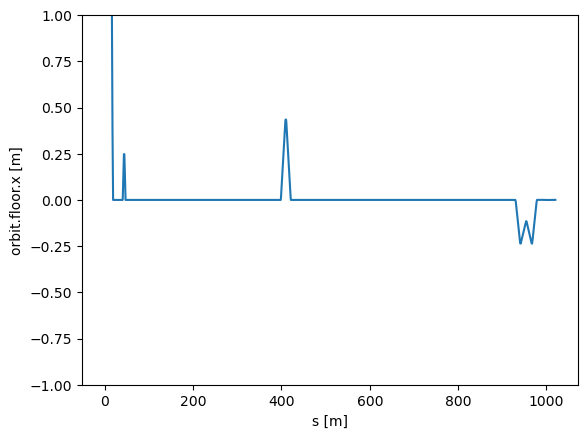

In [14]:
plt.plot(    
    tao.lat_list("*", "ele.s"),
    tao.lat_list("*", "orbit.floor.x")
)
#plt.xlim(0, 5)                 # X-axis from 0 to 5
plt.ylim(-1,1)                # Y-axis from 0 to 20
plt.xlabel("s [m]")         # X-axis label
plt.ylabel("orbit.floor.x [m]")     # Y-axis label

plt.show()

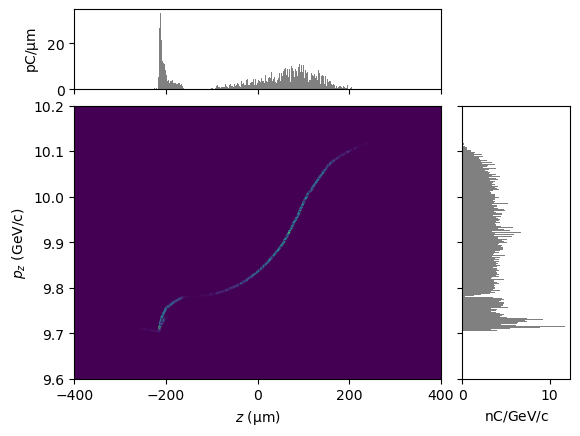

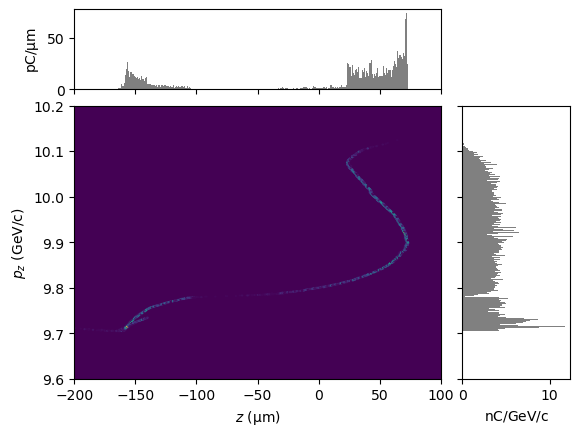

In [15]:
trackBeam(tao, **importedDefaultSettings)

P = getBeamAtElement(tao, "BEGBC20")
display(plotMod(P, 'z', 'pz', bins=300, xlim = (-400e-6, 400e-6), ylim = (9.6e9, 10.2e9)))


P = getBeamAtElement(tao, "PENT")
display(plotMod(P, 'z', 'pz', bins=300, xlim = (-200e-6, 100e-6), ylim = (9.6e9, 10.2e9)))

plt.clf()

## Gradient error only

In [16]:
#Prevent recalculation until changes are made
tao.cmd("set global lattice_calc_on = F")   

#Convert to "turns"
L0BPhaseError = (0.0) / 360.0 
L1PhaseError  = (0.0) / 360.0 
L2PhaseError  = (0.0) / 360.0 
L3PhaseError  = (0.0) / 360.0

[ tao.cmd(f"set ele {ele} PHI0_ERR = {L0BPhaseError}") for ele in L0BMatchStrings ]
[ tao.cmd(f"set ele {ele} PHI0_ERR = {L1PhaseError}")  for ele in L1MatchStrings  ]
[ tao.cmd(f"set ele {ele} PHI0_ERR = {L2PhaseError}")  for ele in L2MatchStrings  ]
[ tao.cmd(f"set ele {ele} PHI0_ERR = {L3PhaseError}")  for ele in L3MatchStrings  ]

#Reenable lattice calculations
tao.cmd("set global lattice_calc_on = T")

[]

In [17]:
L0BGradientErrorRelative =  0.0 / 100.0
L1GradientErrorRelative  =  0.5 / 100.0
L2GradientErrorRelative  =  0.5 / 100.0
L3GradientErrorRelative  =  0.5 / 100.0

#Prevent recalculation until changes are made
tao.cmd("set global lattice_calc_on = F")    

for ele in L0BMatchStrings:
    baseGradient = tao.ele_gen_attribs(ele)["GRADIENT"]
    specificGradientError = L0BGradientErrorRelative * baseGradient
    tao.cmd(f"set ele {ele} GRADIENT_ERR = {specificGradientError}")

for ele in L1MatchStrings:
    baseGradient = tao.ele_gen_attribs(ele)["GRADIENT"]
    specificGradientError = L1GradientErrorRelative * baseGradient
    tao.cmd(f"set ele {ele} GRADIENT_ERR = {specificGradientError}")

for ele in L2MatchStrings:
    baseGradient = tao.ele_gen_attribs(ele)["GRADIENT"]
    specificGradientError = L2GradientErrorRelative * baseGradient
    tao.cmd(f"set ele {ele} GRADIENT_ERR = {specificGradientError}")

for ele in L3MatchStrings:
    baseGradient = tao.ele_gen_attribs(ele)["GRADIENT"]
    specificGradientError = L3GradientErrorRelative * baseGradient
    tao.cmd(f"set ele {ele} GRADIENT_ERR = {specificGradientError}")

#Reenable lattice calculations
tao.cmd("set global lattice_calc_on = T")

[]

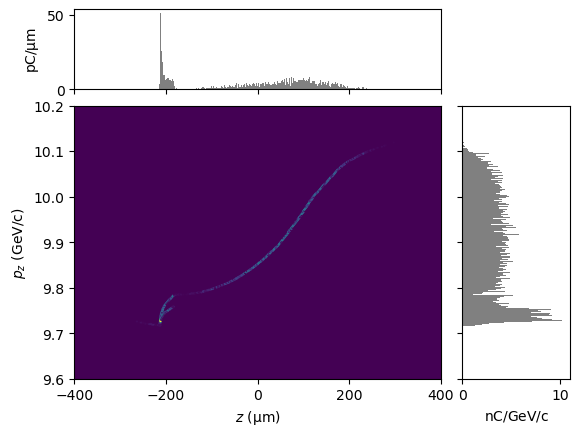

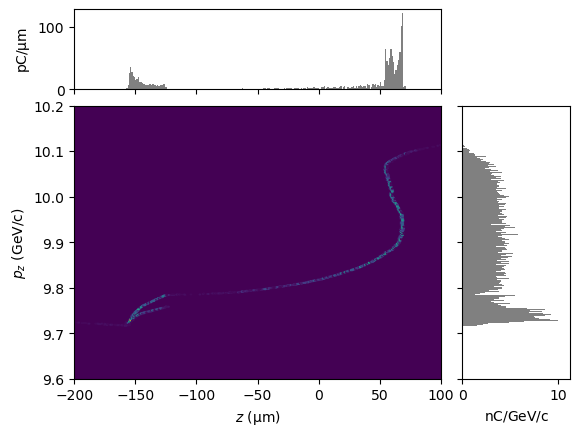

In [18]:
trackBeam(tao, **importedDefaultSettings)

P = getBeamAtElement(tao, "BEGBC20")
display(plotMod(P, 'z', 'pz', bins=300, xlim = (-400e-6, 400e-6), ylim = (9.6e9, 10.2e9)))


P = getBeamAtElement(tao, "PENT")
display(plotMod(P, 'z', 'pz', bins=300, xlim = (-200e-6, 100e-6), ylim = (9.6e9, 10.2e9)))

plt.clf()

## Discussion

So it seems that whenever either PHI0_ERR or GRADIENT_ERR are nonzero AND CSR is enabled, BC20 goes completely bonkers. This can be verified by looking at BEGBC20 and finding a reasonable distribution there.

Aperatures need to be disabled to even see this effect; with them on, beam is lost on Q1EL and Bmad crashes.

Barring a patch to Bmad, I think this means I either need to be satisfied with jitter sims which neglect CSR? Or I'll need to mess with the phase and gradient directly, while disabling magnet autocompensation... 